# Дизайн эксперимента и подготовка данных

Давайте представим, что вы работаете в команде разработчиков среднего интернет-магазина. UX-дизайнер очень усердно работал над новой версией страницы продукта в надежде, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту (PM) сказал вам, что текущий коэффициент конверсии составляет около 13% в среднем в течение года, и что команда была бы рада увеличению на 2%, а это означает, что новый дизайн будет считаться успешным, если он повысит коэффициент конверсии до 15%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

A/B testing on Discrete metrics: conversion rate.

In [4]:
df = pd.read_csv(r'C:\Users\Lily_B\Documents\аналитика на python\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [27]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [29]:
df['user_id'].nunique()

290584

Всего строк 294478 из них уникальных 290584.

Найдем пользователей, которые попали в обе группы одновременно или были дважды добавлены в одну и ту же группу.

In [11]:
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [34]:
df[df["user_id"] == 899953]

,user_id,timestamp,group,landing_page,converted
3489,899953,2017-01-05 05:36:02.120641,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0


Теперь посмотрим, есть ли несоответствия в данных. landing_page у treatment group должен быть new_page, у control group - old_page. Посмотрим, сколько всего несоответствий.

In [53]:
df_mistake = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mistake = len(df_mistake)

In [54]:
print(f'Количество ошибочных строк:{n_mistake}')

Количество ошибочных строк:3893


In [55]:
print(f'Процентное соотношение ошибочных строк к общему количеству:{round(n_mistake/len(df)*100, 2)}%')

Процентное соотношение ошибочных строк к общему количеству:1.32%


3894 - дублируются и 3893 ошибочные. Сохраним правильные данные и удалим несоответствующие.

In [158]:
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]
df2

,user_id,timestamp,group,landing_page,converted,control_count
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1


In [115]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted,control_count
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,0


In [116]:
df2.drop(np.where(df2["user_id"] == 773192)[0])

,user_id,timestamp,group,landing_page,converted,control_count
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1


В итоге получилось 290583. Посчитаем коэффициент конверсии (Conversion Rate).

In [156]:
df_counts = pd.DataFrame(df2.groupby(['group', 'landing_page'])['converted'].value_counts())
df_counts

converted
group     landing_page converted           
control   old_page     0             127785
                       1              17489
treatment new_page     0             128047
                       1              17264

In [177]:
# Conversion Rate
df_counts = pd.DataFrame({"Control_count": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_count": df2[df2.group=="treatment"].converted.value_counts(),
              "Control_ratio": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
              "Trement_ratio": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})
df_counts

,Control_count,Treatment_count,Control_ratio,Trement_ratio
0,127785,128047,0.879614,0.881193
1,17489,17264,0.120386,0.118807


# Визуализация

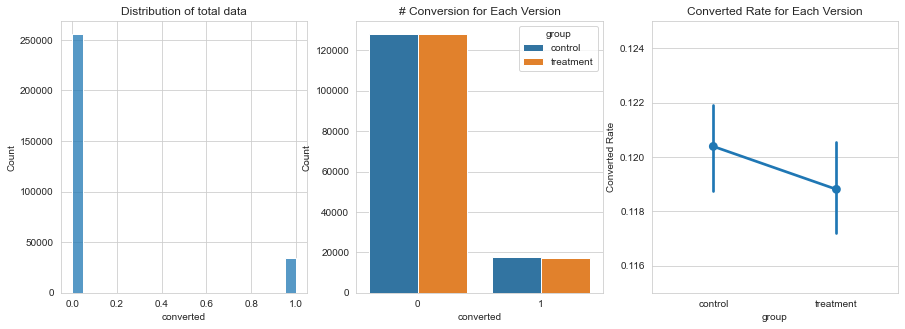

In [146]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
fig, axes = plt.subplots(1,3)

sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of total data")

sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set(title="# Conversion for Each Version", ylabel="Count")

sns.pointplot(x="group", y="converted",kind="point", data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])
axes[2].set(title="Converted Rate for Each Version",ylabel="Converted Rate")

plt.show()

Размер выборки большой, поэтому тут подойдет Ки-квадрат Пирсона. Новый коэффициент конверсии немного ниже, чем старый, но также присутствуют некоторые совпадения.

# Проверка гипотез

H0: коэффициент конверсиия контрольной группы = коэффициенту конверсии тестовой группы

Н1: коэффициент конверсиия контрольной группы != коэффициенту конверсии тестовой группы

In [178]:
table = df_counts.iloc[:,0:2].to_numpy()
table

array([[127785, 128047],
       [ 17489,  17264]], dtype=int64)

In [179]:
# chi-squared test
prob = 0.95
alpha = 0.05
stat, p, dof, expected = stats.chi2_contingency(table)

In [180]:
critical = stats.chi2.ppf(prob, dof)

In [190]:
print(f'probability={prob:.2f}, critical={critical:.2f}, stat={stat:.2f}, p_val={p:.2f}')

probability=0.95, critical=3.84, stat=1.71, p_val=0.19


In [192]:
# Fishers exact test on the data
odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
print(f'odd_ratio={odd_ratio:.2f}, p_value={p_value:.2f}')

odd_ratio=0.99, p_value=0.19


Попробуем посчитать с помощью Bootstrap

In [203]:
n = 1000
result = []

for _ in tqdm(range(n)):
    a = df.sample(127785,replace=True)['converted'].mean()
    b = df.sample(128047,replace=True)['converted'].mean()
    stat, p, dof, expected = stats.chi2_contingency(table)
    result.append(p)

In [205]:
round(np.mean(result), 2)

0.19

Если выборка небольшая, то лучше использовать тест Фишера. Три теста показали одинаковое p_val. Так как 0.19 > 0.05, то мы принимаем нашу нулевую гипотезу и считаем, что группы одинаковы.